# Learning

In [2]:
import numpy as np

import pandas as pd
import matplotlib.pylab as plt

from astropy.io import fits
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as units

from uncertainties import ufloat
from collections import Counter

from functions import *

%matplotlib inline

## Parameters

In [3]:
# Stephen's UNIONS+SDSS
#base_name = 'unions.ugriz'

# Stephen's UNIONS+DEEP3
base_name = 'w3.ugriz.spec'

# Stephen's UNIONS MK-matched with SDSS
#base_name = 'unions.ugriz2'

In [4]:
# Input parameters
bands = ['u', 'g', 'r', 'i', 'z']
path_to_csv = f'{base_name}_matched.csv'

In [5]:
output_name = 'out'
output_path = './'
temp_path = 'temp/'

survey = 'UNIONS_800_MKmatch_SDSS'

# Action on missing data
preprocessing = 'drop'

# number of samples for cross-validation, default=4
cv = 4

In [6]:
GenFiles = GenerateFiles(survey, bands, temp_path, output_name, output_path)
GenFiles.clean_temp_directories()
for f in [False, True]:
    GenFiles.make_directories(output=f)

Successfully removed the directory temp/UNIONS_800_MKmatch_SDSS/d2d/ 
Successfully removed the directory temp/UNIONS_800_MKmatch_SDSS/matched/ 
Successfully removed the directory temp/UNIONS_800_MKmatch_SDSS/unmatched/ 
Successfully removed the directory temp/UNIONS_800_MKmatch_SDSS/vignet/ 
Successfully removed the directory temp/UNIONS_800_MKmatch_SDSS/redshift/ 
Successfully removed the directory temp/UNIONS_800_MKmatch_SDSS/spectral_surveys/ 
Successfully created the directory temp/UNIONS_800_MKmatch_SDSS/vignet/u 
Successfully created the directory temp/UNIONS_800_MKmatch_SDSS/vignet/g 
Successfully created the directory temp/UNIONS_800_MKmatch_SDSS/vignet/r 
Successfully created the directory temp/UNIONS_800_MKmatch_SDSS/vignet/i 
Successfully created the directory temp/UNIONS_800_MKmatch_SDSS/vignet/z 
Successfully created the directory temp/UNIONS_800_MKmatch_SDSS/vignet/array 


In [7]:
# Set up ML class
ML = LearningAlgorithms(
    survey=survey,
    bands=bands,
    path_to_csv=path_to_csv,
    output_name=output_name,
    output_path=output_path,
    cv=cv,
    preprocessing=preprocessing,
    n_jobs=1
)

In [8]:
# Create links
dst = f'output/{survey}/{output_name}/files/{output_name}.csv'
src = f'{os.getcwd()}/{base_name}_matched.csv'
if not os.path.exists(dst):
    os.symlink(src, dst)

In [9]:
df_matched = pd.read_csv(f'{base_name}_matched.csv')
df = df_matched

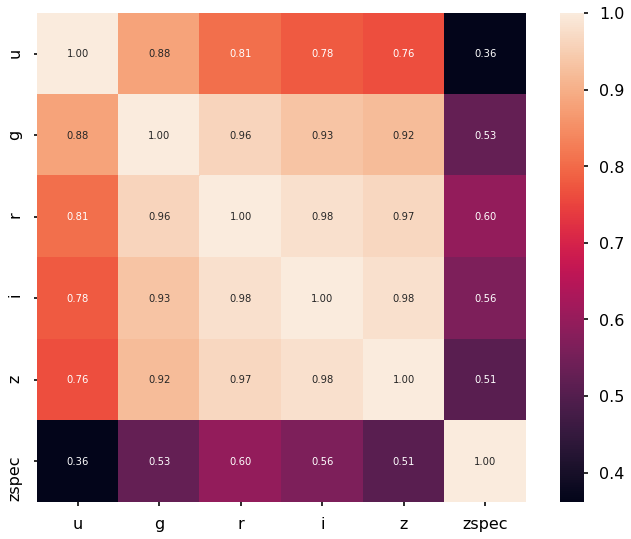

In [10]:
# Plot correlation matrix
ML.plot_corrmat(df_matched)

In [11]:
# Set up ML algorithms

algs = {'RF': RandomForest}
weights = None
method = {}

for alg_name in algs:
    best_score = 1
    alg = algs[alg_name]
    method[alg_name] = alg(
        survey=survey,
        bands=bands,
        output_name=output_name,
        temp_path=temp_path,
        dataframe=df_matched,
        path_to_csv=None,
        validation_set=False,
        output_path=output_path,
        sample_weight=weights,
        cv=cv,
        preprocessing=preprocessing,
        n_jobs=1
    )

In [12]:
# Run ML algorithms
score = {}
y_pred_dict = {}
y_test_dict = {}

for alg_name in algs:

    # Get score from cross-validation
    score[alg_name] = method[alg_name].score(df)

    # Get model data
    _, y_pred, y_test = method[alg_name].model()
    y_pred_dict[alg_name] = y_pred
    y_test_dict[alg_name] = y_test

100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


In [13]:
# Print sigma and eta with error bars, as computed from cross-validation
for alg_name in algs:
    sigma = ufloat(score[alg_name][0], score[alg_name][1])
    eta = ufloat(score[alg_name][2], score[alg_name][3])
    print(
        f'{alg_name}: sigma={sigma:.3gP}, '
        + f'eta={eta:.3gP}',
        end='\r'
    )

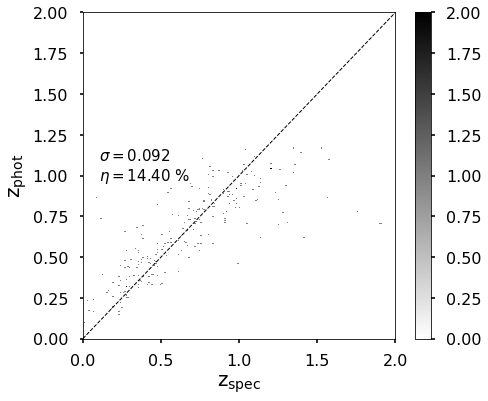

In [14]:
# Plot
lim = 2
for alg_name in algs:
    method[alg_name].plot_zphot_zspec(y_pred_dict[alg_name], y_test_dict[alg_name], 'RF', lim, nbins=200)

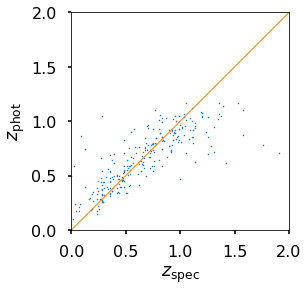

In [15]:
fig, (ax) = plt.subplots(1, 1)

ax.plot(y_test_dict['RF'], y_pred_dict['RF'], '.', markersize=3)
ax.plot([0, lim], [0, lim], '-', linewidth=1)
ax.set_ylim(0, lim)
ax.set_xlim(0, lim)
ax.set_xlabel(r'$z_{\rm spec}$')
ax.set_ylabel(r'$z_{\rm phot}$')
ax.set_aspect('equal')
_ = plt.savefig(f'{output_path}/output/{survey}/{output_name}/figures/out_RF_zphot_zspec_2.pdf')

In [16]:
len(y_test_dict['RF'])

257

In [19]:
method['RF'].model()

AttributeError: 'tuple' object has no attribute 'shape'